<a href="https://colab.research.google.com/github/sriksmachi/sriksml/blob/main/genai/transformers_101_nmt_eng_hin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transformers 101.

In this notebook we will create a transformer model using multi-headed attention for neural machine translation task.

A little bit about transformers, before we get started.
RNNs were traditionally used for modelling seq2seq tasks, however they fail when the length of the sequence of input increases. The attention mechanism was introduced with idea to identify the relative weights of each words with respect to the other words so that the model can learn selectively.

Attention technique used with RNNs help learn hidden state for each word so that it is easy to pay more attention or discard words rather than learning the hidden state for the entire sentence. However this does not solve 3 problems

1.   The entire process is still sequential, it cannot be parallelized
2.   For a large sentence the time taken for translating the sentence to encodings is large.

Transformers introduced a completely new concept, with some learnings from how CNNs learn embeddings in parallel. Transformers use encoder, decoder architecture to learn attention weights in parallel and they can be used for a variety of tasks like neural language translation, question answering, next word prediction etc.

Complete understanding of how transformers work is not explained in this notebook but you may refer to the following blogs for better understanding.
- https://jalammar.github.io/illustrated-transformer/
- https://mchromiak.github.io/articles/2017/Sep/12/Transformer-Attention-is-all-you-need/#.XIWlzBNKjOR

This notebook builds a transformer model following the explanation from the original paper (https://arxiv.org/pdf/1706.03762.pdf). The implementation is taken from articles published at https://machinelearningmastery.com/building-transformer-models-with-attention-crash-course-build-a-neural-machine-translator-in-12-days/.



In [1]:
## Importing required libraries

import tensorflow as tf
from tensorflow import matmul, cast, float32,sqrt, math, transpose
from tensorflow import convert_to_tensor, string
from keras.backend import softmax
from numpy import random
from tensorflow.keras.layers import TextVectorization, Embedding, Layer, Dropout, Input
from tensorflow.keras import Model
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pickle
import random
import re
import tqdm
import unicodedata
import tensorflow as tf
from tensorflow import convert_to_tensor, int64
from pickle import load
from numpy.random import shuffle
import pandas as pd

## Transformers Architecture.

Image Source :  https://arxiv.org/pdf/1706.03762.pdf

We will use the bottom-up approach, i.e. build the transformer from the bottom most layer and then walk upwards. This notebook builds each layer as a separate model so that they can be plugged into a full fledged model.

## Download and Preprocess

In [2]:
!gdown 1vyR40sftEJ1Jexoat17JzzB2cdcMVI0T

Downloading...
From: https://drive.google.com/uc?id=1vyR40sftEJ1Jexoat17JzzB2cdcMVI0T
To: /content/Hindi_English_Truncated_Corpus.csv
100% 41.4M/41.4M [00:00<00:00, 107MB/s] 


In [3]:
ds = pd.read_csv('/content/Hindi_English_Truncated_Corpus.csv')
print(f'Total number of examples = {len(ds)}')
ds.head()

Total number of examples = 127607


,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [4]:
ds['eng_len']=ds['english_sentence'].apply(lambda x:len(str(x).split(" ")))
ds['hin_len']=ds['hindi_sentence'].apply(lambda x:len(str(x).split(" ")))
ds.head()

,source,english_sentence,hindi_sentence,eng_len,hin_len
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर...",12,14
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...,9,11
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।,10,9
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते,12,11
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।,9,8


Let us take only sentences less than 15 words to reduce training time.

In [5]:
ds = ds[(ds['eng_len'] < 15)]
ds = ds[(ds['hin_len'] < 15)]
print(f'Total number of examples = {len(ds)}')

Total number of examples = 66074


In [6]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
ds['english_sentence']=ds['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in filters))


In [7]:
n_sentences = None
batch_size=32
if n_sentences is not None:
    ds = ds.head(n_sentences)
print(f'Total number of examples = {len(ds)}')

Total number of examples = 66074


In [8]:
ds['english_sentence'] = ds['english_sentence'].apply(lambda x: "[start] " + x + " [end]")
ds['hindi_sentence'] = ds['hindi_sentence'].apply(lambda x: "[start] " + x + " [end]")
ds.head()

,source,english_sentence,hindi_sentence,eng_len,hin_len
0,ted,[start] politicians do not have permission to ...,[start] राजनीतिज्ञों के पास जो कार्य करना चाहि...,12,14
1,ted,[start] I'd like to tell you about one such ch...,[start] मई आपको ऐसे ही एक बच्चे के बारे में बत...,9,11
2,indic2012,[start] This percentage is even greater than t...,[start] यह प्रतिशत भारत में हिन्दुओं प्रतिशत स...,10,9
3,ted,[start] what we really mean is that they're ba...,[start] हम ये नहीं कहना चाहते कि वो ध्यान नहीं...,12,11
4,indic2012,[start] The ending portion of these Vedas is c...,[start] इन्हीं वेदों का अंतिम भाग उपनिषद कहलात...,9,8


In [9]:

def normalize(eng, hin):
    """Normalize a line of text and split into two at the tab character"""
    line = str(eng.strip().lower()) + "\t" + str(hin.strip())
    line = unicodedata.normalize("NFD", line)
    line = line.encode("ascii", "ignore").decode("utf-8")
    line = line.strip()
    eng, hind = line.split('\t')
    return eng, hin

text_pairs = []
for index in ds.index:
    text_pairs.append(normalize(ds['english_sentence'][index], ds['hindi_sentence'][index]))
print(len(text_pairs))

66074


## Parameters

In [10]:
batch_size=32

In [11]:
# Create train, val and testing datasets
val_split = 0.30

len_text_pairs = len(text_pairs)
n_val_index = int(val_split * len_text_pairs)
n_train_index = len_text_pairs - n_val_index

train_tp = text_pairs[:n_train_index]
val_tp = text_pairs[n_train_index:]
print(f"Train: {len(train_tp)}")
print(f"Validation: {len(val_tp)}")

Train: 46252
Validation: 19822


In [12]:
train_tp[:1]

[('[start] politicians do not have permission to do what needs to be done [end]',
  '[start] राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह करने कि अनुमति नहीं है . [end]')]

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

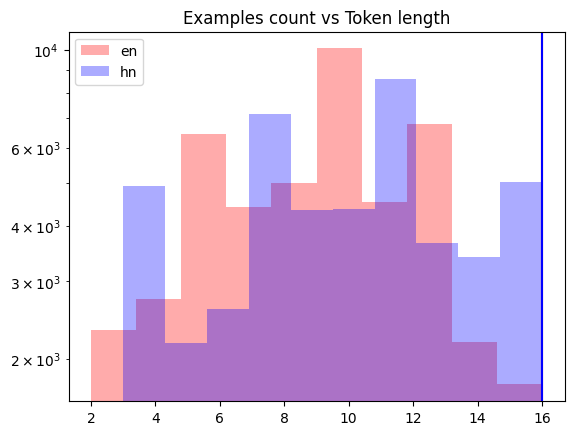

In [13]:
# histogram of sentence length in tokens
en_lengths = [len(e.split()) for e, h in train_tp]
hn_lengths = [len(h.split()) for e, h in train_tp]

plt.hist(en_lengths, label="en", color="red", alpha=0.33)
plt.hist(hn_lengths, label="hn", color="blue", alpha=0.33)
plt.yscale("log")     # sentence length fits Benford"s law
plt.ylim(plt.ylim())  # make y-axis consistent for both plots
plt.plot([max(en_lengths), max(en_lengths)], plt.ylim(), color="red")
plt.plot([max(hn_lengths), max(hn_lengths)], plt.ylim(), color="blue")
plt.legend()
plt.title("Examples count vs Token length")
plt.show()

In [14]:
 # count tokens
eng_tokens, hin_tokens = set(), set()
eng_maxlen, hin_maxlen = 0, 0
for eng, hin in text_pairs:
    eng_tok, hin_tok = eng.split(), hin.split()
    eng_maxlen = max(eng_maxlen, len(eng_tok))
    fra_maxlen = max(hin_maxlen, len(hin_tok))
    eng_tokens.update(eng_tok)
    hin_tokens.update(hin_tok)
print(f"Total English tokens: {len(eng_tokens)}")
print(f"Total Hindi tokens: {len(hin_tokens)}")
print(f"Max English length: {eng_maxlen}")
print(f"Max Hindi length: {fra_maxlen}")
print(f"{len(text_pairs)} total pairs")
vocab_size_en = len(eng_tokens)
vocab_size_hn = len(hin_tokens)

Total English tokens: 31126
Total Hindi tokens: 37674
Max English length: 16
Max Hindi length: 16
66074 total pairs


In [15]:
seq_length = 15

# Create vectorizer
eng_vectorizer = TextVectorization(
    max_tokens=vocab_size_en,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length,
)

hin_vectorizer = TextVectorization(
    max_tokens=vocab_size_hn,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length + 1
)


## Prepare dataset

In [16]:
train_eng_texts = [pairs[0] for pairs in train_tp]
train_hin_texts = [pairs[1] for pairs in train_tp]

eng_vectorizer.adapt(train_eng_texts)
hin_vectorizer.adapt(train_hin_texts)

# set up Dataset object
def format_dataset(eng, hin):
    eng = eng_vectorizer(eng)
    hin = hin_vectorizer(hin)
    source = (eng, hin[:, :-1])
    target = hin[:, 1:]
    return (source, target)

def make_dataset(pairs, batch_size=64):
    """Create TensorFlow Dataset for the sentence pairs"""
    # aggregate sentences using zip(*pairs)
    eng_texts, hin_texts = zip(*pairs)
    # convert them into list, and then create tensors
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(hin_texts)))
    return dataset.shuffle(2048) \
                  .batch(batch_size).map(format_dataset) \
                  .prefetch(16).cache()

train_ds = make_dataset(train_tp)
val_ds = make_dataset(val_tp)

In [17]:
# test the dataset
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs[0].shape}')
    print(f'inputs["encoder_inputs"][0]: {inputs[0][0]}')
    print(f'inputs["decoder_inputs"].shape: {inputs[1].shape}')
    print(f'inputs["decoder_inputs"][0]: {inputs[1][0]}')
    print(f"targets.shape: {targets.shape}")
    print(f"targets[0]: {targets[0]}")

inputs["encoder_inputs"].shape: (64, 15)
inputs["encoder_inputs"][0]: [   2   46 8509 2285 7768 3057 2285 1439    3    0    0    0    0    0
    0]
inputs["decoder_inputs"].shape: (64, 15)
inputs["decoder_inputs"][0]: [    2   721  3511 29210 21088  3511 13684     3     0     0     0     0
     0     0     0]
targets.shape: (64, 15)
targets[0]: [  721  3511 29210 21088  3511 13684     3     0     0     0     0     0
     0     0     0]


In [18]:
eng_lookup = list(eng_vectorizer.get_vocabulary())
hin_lookup = list(hin_vectorizer.get_vocabulary())
eng_sen, hin_sen, hin_source = "", "",""
print(inputs[1].shape)
for index in inputs[0][0]:
  eng_sen += eng_lookup[index.numpy()] + " "
for index in targets[0]:
  hin_source += hin_lookup[index.numpy()] + " "
print(f"source: {eng_sen}")
print(f"hin source: {hin_source}")

(64, 15)
source: [start] it's arabs versus israelis labor versus management [end]       
hin source: अरब बनाम इस्राइली, मज़दूर बनाम प्रबंधन, [end]         


## Vocab size

In [19]:
# find out how many distinct tokens exist
print(f"Total English tokens = {vocab_size_en}.")
print(f"Total Hindi tokens = {vocab_size_hn}.")

Total English tokens = 31126.
Total Hindi tokens = 37674.


In [20]:
for (eng, hin), hn_labels in train_ds.take(1):
  break
print(eng.shape)
print(hin.shape)
print(hn_labels.shape)

print(hin[0][:10])
print(hn_labels[0][:10])

(64, 15)
(64, 15)
(64, 15)
tf.Tensor([   2 2564  431    7   35  259   36  236    3    0], shape=(10,), dtype=int64)
tf.Tensor([2564  431    7   35  259   36  236    3    0    0], shape=(10,), dtype=int64)


## Positional Embedding Layer



In [21]:
# Positional embedding matrix - This matrix represents the position of the word in the sentence.
# It takes input as length of the sentence and size of the vector embeddings
# The output is a matrix where every row is a word in the sentence, each row represents the position encoding of that word
# The length of each row is equal to the length of word embeddings.
def positional_encoding(length, depth):
  depth = depth/2
  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)
  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)
  return tf.cast(pos_encoding, dtype=tf.float32)

pos_matrix = positional_encoding(4, 4)
assert pos_matrix.shape == (4,4)
print(pos_matrix.shape)
print(pos_matrix)


(4, 4)
tf.Tensor(
[[ 0.          0.          1.          1.        ]
 [ 0.84147096  0.00999983  0.5403023   0.99995   ]
 [ 0.9092974   0.01999867 -0.41614684  0.9998    ]
 [ 0.14112     0.0299955  -0.9899925   0.99955004]], shape=(4, 4), dtype=float32)


In [22]:
# Positional Embedding
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [23]:
eng_pos = PositionalEmbedding(vocab_size_en, 512)
hin_pos = PositionalEmbedding(vocab_size_hn, 512)
print(eng_pos(eng).shape)
print(hin_pos(hin).shape)

(64, 15, 512)
(64, 15, 512)



## Self Attention Layer

In [24]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [25]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)
enc_output = eng_pos(eng)
print(enc_output.shape)
print(sample_gsa(enc_output).shape)

(64, 15, 512)
(64, 15, 512)


## Cross Attention Layer

In [26]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [27]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)
emb_output_eng = eng_pos(eng)
emb_output_hin = hin_pos(hin)
print(emb_output_eng.shape)
print(emb_output_hin.shape)
print(sample_ca(emb_output_eng, emb_output_hin).shape)

(64, 15, 512)
(64, 15, 512)
(64, 15, 512)


## Causal Self Attention

In [28]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [29]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)
emb_output_eng = eng_pos(eng)
print(emb_output_eng.shape)
print(sample_csa(emb_output_eng).shape)

(64, 15, 512)
(64, 15, 512)


## Feedforward Layer

In [30]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x


In [31]:
sample_ffn = FeedForward(512, 2048)
print(sample_ffn(emb_output_eng).shape)

(64, 15, 512)


## Encoder

In [32]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()
    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [33]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)
print(emb_output_eng.shape)
print(sample_encoder_layer(emb_output_eng).shape)

(64, 15, 512)
(64, 15, 512)


In [34]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)
    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    # Add dropout.
    x = self.dropout(x)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)
    return x  # Shape `(batch_size, seq_len, d_model)`.

In [35]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=vocab_size_en)
sample_encoder_output = sample_encoder(eng, training=False)
print(eng.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 15)
(64, 15, 512)


## Decoder

In [36]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()
    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)
    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores
    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [37]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)
    self.last_attn_scores = self.dec_layers[-1].last_attn_scores
    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [38]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=vocab_size_hn)
output = sample_decoder(x=hin,context=emb_output_eng)
# Print the shapes.
print(hin.shape)
print(emb_output_hin.shape)
print(output.shape)

(64, 15)
(64, 15, 512)
(64, 15, 512)


In [39]:
sample_decoder.last_attn_scores.shape

TensorShape([64, 8, 15, 15])

## Transformer Model

In [40]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs
    context = self.encoder(context)  # (batch_size, context_len, d_model)
    x = self.decoder(x, context)  # (batch_size, target_len, d_model)
    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)
    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

## Training Utilities

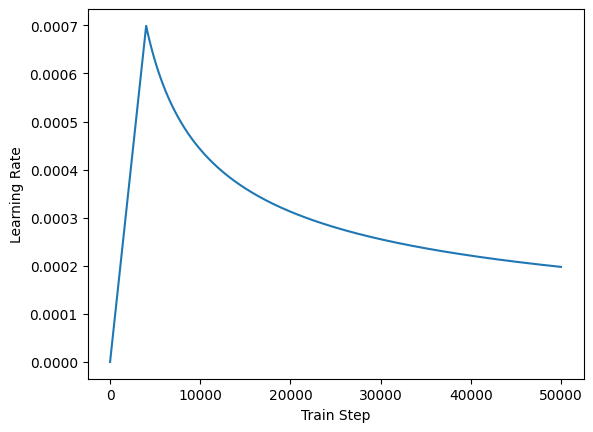

In [41]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, key_dim, warmup_steps=4000):
    super().__init__()
    self.key_dim=key_dim
    self.warmup_steps=warmup_steps
    self.d=tf.cast(self.key_dim, tf.float32)

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    config = {
        "key_dim": self.key_dim,
        "warmup_steps": self.warmup_steps
    }
    return config

key_dim = 512
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
plt.plot(lr(tf.range(50000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [42]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = loss_object(label, pred)
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, dtype=pred.dtype)
  match = pred==label
  mask = label !=0
  match = match & mask
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match) / tf.reduce_sum(mask)


## Final Model

In [43]:
# Parameters
n_sentences = None
num_layers = 4
d_model = 512
dff = 512
num_heads = 8
dropout_rate = 0.2

In [44]:
model = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=vocab_size_en,
    target_vocab_size=vocab_size_hn,
    dropout_rate=dropout_rate)
lr = CustomSchedule(512)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])


## Training

Epoch 1/15
723/723 [==============================] - 337s 428ms/step - loss: 7.6864 - masked_accuracy: 0.1362 - val_loss: 6.2269 - val_masked_accuracy: 0.1985
Epoch 2/15
723/723 [==============================] - 306s 423ms/step - loss: 5.7349 - masked_accuracy: 0.2323 - val_loss: 5.4802 - val_masked_accuracy: 0.2643
Epoch 3/15
723/723 [==============================] - 306s 424ms/step - loss: 5.0229 - masked_accuracy: 0.2828 - val_loss: 5.1106 - val_masked_accuracy: 0.2970
Epoch 4/15
723/723 [==============================] - 306s 423ms/step - loss: 4.4843 - masked_accuracy: 0.3226 - val_loss: 4.9016 - val_masked_accuracy: 0.3150
Epoch 5/15
723/723 [==============================] - 306s 423ms/step - loss: 4.0151 - masked_accuracy: 0.3582 - val_loss: 4.7609 - val_masked_accuracy: 0.3335
Epoch 6/15
723/723 [==============================] - 306s 423ms/step - loss: 3.5947 - masked_accuracy: 0.3956 - val_loss: 4.6646 - val_masked_accuracy: 0.3475
Epoch 7/15
723/723 [====================

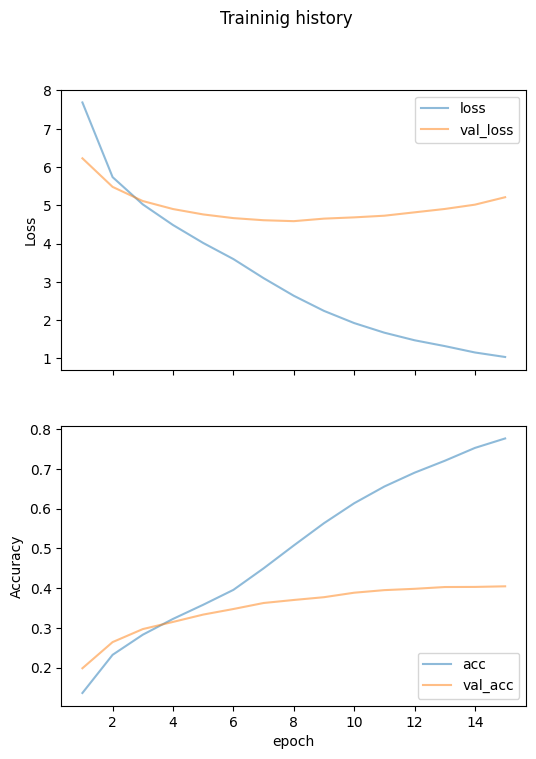

In [45]:
epochs = 15
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Plot the loss and accuracy history
fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)
fig.suptitle('Traininig history')
x = list(range(1, epochs+1))
axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
axs[0].plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, history.history["masked_accuracy"], alpha=0.5, label="acc")
axs[1].plot(x, history.history["val_masked_accuracy"], alpha=0.5, label="val_acc")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("epoch")
axs[1].legend(loc="lower right")
plt.show()

In [46]:
# training parameters used
seq_len = 20
def translate(sentence):
    """Create the translated sentence"""
    enc_tokens = eng_vectorizer([sentence])
    lookup = list(hin_vectorizer.get_vocabulary())
    start_sentinel, end_sentinel = "[start]", "[end]"
    output_sentence = [start_sentinel]
    # generate the translated sentence word by word
    for i in range(seq_len):
        vector = hin_vectorizer([" ".join(output_sentence)])
        dec_tokens = vector[:, :-1]
        pred = model([enc_tokens, dec_tokens])
        word = lookup[np.argmax(pred[0, i, :])]
        output_sentence.append(word)
        if word == end_sentinel:
            break
    return output_sentence

test_count = 5
for n in range(test_count):
    english_sentence, Hindi_sentence = random.choice(val_tp)
    translated = translate(english_sentence)
    print(f"Test {n}:")
    print(f"{english_sentence}")
    print(f"== {Hindi_sentence}")
    print(f"-> {' '.join(translated)}")
    print()

Test 0:
[start] because by the time you're a social worker for 10 years [end]
== [start] क्योंकि 10 सालों तक समाज सेवा करने के बाद, [end]
-> [start] क्यूंकि आप दस साल के शहर में एक सामाजिक क्रांतिकारी होना चाहिए. [end]

Test 1:
[start] to suss out clues [end]
== [start] उन ग्रहों के सुरागो को [end]
-> [start] वाह्य सूत्र [end]

Test 2:
[start] that is why millions of people doodle [end]
== [start] इसलिये दसियों लाख लोग ऐसा करते हैं। [end]
-> [start] इसीलिए आम मेक्सिको के लोग इस कारण हैं कि [end]

Test 3:
[start] uttarkand is the epilogue of the rama's story [end]
== [start] उत्तरकाण्ड राम कथा का उपसंहार है। [end]
-> [start] उत्तरकाण्ड का समापन राम की संतोपंथ की चोटियों में है। [end]

Test 4:
[start] and they are deliberately distorting it [end]
== [start] और वे जान - बूझकर उसे विकृत कर रहे हैं [end]
-> [start] और वे वनस्पति विविधता का स्रोत बना रहे हैं, [end]

